In [1]:
import os
import numpy as np
import jax.numpy as jnp
from jax import jit, lax

os.environ["CUDA_DEVICE_ORDER"] = (
    "PCI_BUS_ID"  # see issue #152 # comment this out for mac cpu
)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import jax
jax.default_backend()

'gpu'

In [3]:
jax.devices()

[cuda(id=0)]

### Solve a diffusion equation.<br>

As the first example, we solve a steady-state diffusion equation of the following form

$$\nabla\cdot\left(- \Gamma \nabla \phi \right)= S_Q$$

where $\Gamma$ is the diffusivity and $\phi$ is the concentration. 

Let me assume that we have a 3D cube domain, with Dirichlet boundary conditions at boundaries. First of all, we need to define our domain, discretize it, and define the boundaries at the borders.

*Note:*  This is a boundary value problem and we will be solving for the steady-state solution, without any transient term.

The next step is to define the diffusion coefficient. 

The physical properties $\Gamma$ defined for each face, as a `jnp array` with shape Nf.

Boundary infomation, stored in `bd_info` dictionary

The source term $S_Q$ stored in each cell, as a `jnp array` with shape Nc.

And the initial guess of the solutions

In [4]:
# define GT
def fx(x):
    return x**3 * (x - 1) * jnp.exp(-(x**2))


def fx_prime2(x):
    return (
        4 * x**5 * (x - 1) * jnp.exp(-(x**2))
        - 4 * x**4 * jnp.exp(-(x**2))
        - 14 * x**3 * (x - 1) * jnp.exp(-(x**2))
        + 6 * x**2 * jnp.exp(-(x**2))
        + 6 * x * (x - 1) * jnp.exp(-(x**2))
    )


def fy(x):
    return x * (x - 1) * jnp.sin(jnp.pi * x)


def fy_prime2(x):
    return (
        -jnp.pi**2 * x * (x - 1) * jnp.sin(jnp.pi * x)
        + 2 * jnp.pi * x * jnp.cos(jnp.pi * x)
        + 2 * jnp.pi * (x - 1) * np.cos(jnp.pi * x)
        + 2 * jnp.sin(jnp.pi * x)
    )


def fz(x):
    return x**4 - x


def fz_prime2(x):
    return 12 * x**2


def get_gt_foi(X):
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    return 1000 * (fx(x) * fy(y) * fz(z)) + 10


def get_gt_grad2foi(X):
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    return 1000 * (
        fx_prime2(x) * fy(y) * fz(z)
        + fx(x) * fy_prime2(y) * fz(z)
        + fx(x) * fy(y) * fz_prime2(z)
    )


# diffusion coefficient field
Gamma = 10.0

def get_gamma(X):
    return Gamma + jnp.sum(0.0 * X, axis=1)
    # return 1.004+ jnp.sum(0.*x, axis = 1)


# diffusion coefficient field
def get_initial_guess(X):
    return 10.0 + jnp.sum(0.0 * X, axis=1)


def get_source(X):
    """
    according to grad(-gamma*grad(phi)) = source
    """
    return -get_gamma(X) * get_gt_grad2foi(X)


bd_infos = {
    "T": (
        ("top", 0, "Uniform", 10.0),
        ("bottom", 0, "Uniform", 10.0),
        ("back", 0, "Uniform", 10.0),
        ("right", 0, "Uniform", 10.0),
        ("front", 0, "Uniform", 10.0),
        ("left", 0, "Uniform", 10.0),
    )
}

fvSchemes = {
    "ddtSchemes": "steadyState",
    "gradSchemes": "Gauss linear",
    #  'gradSchemes': 'Gauss linear corrected',
    "divSchemes": "none",
    "laplacianSchemes": "Gauss linear corrected",
    "interpolateionSchemes": "linear",
    "snGradSchemes": "corrected",
}

fvSolution = {
    "solvers": {
        "T": {
            "solver": "smoothSolver",
            "smoother": "DILU",
            "tolerance": 1e-6,
            "relTol": 0,
        },
    },
    "SIMPLE": {"redidualControl": {"T": 1e-12}},
    "relaxationFactors": {"equations": {"T": 0.9}},
}

controlDict = {
    "startTime": 0.0,
    "endTime": 10.0,
    "delta T": 1.0,
    "writInterval": 5,
    "gradSchemesMaxIter": 10,
}

transportProperties = {"Dt": ("Dt", (0, 2, -1, 0, 0, 0, 0), 1e-3)}

Simulation_input = {
    "source": get_source,
    "gamma": Gamma,
    "gt": get_gt_foi,
    "fvSchemes": fvSchemes,
    "fvSolution": fvSolution,
    "controlDict": controlDict,
    "transportProperties": transportProperties,
}

In [5]:
# Read in grid
from grids import Grid, BoundaryConditions

grid = Grid(
    np.load("/home/yongqi/JAX-IGA/jax_torch_fvm/raw_data/mesh/mesh_basic_np.npz")
)

# Set up simulation
grid.SetUpSimulation("SteadyDiffusion", **Simulation_input)

# Creat initial field object with B.C.
from initial_condition import InitialScalarField

mybc = BoundaryConditions(bd_infos["T"], grid)
v0 = InitialScalarField(get_initial_guess, grid, mybc, name="T").UpdateBoundaryPhi(grid)

In [6]:
# Set up simulation
grid.SetUpSimulation("SteadyDiffusion", **Simulation_input)

print("Gamma:",grid.gamma)
print("Shape of gamma array == Num of faces:", grid.gamma.shape[0] == grid.N_f,"\n")
print("Source Term:", grid.source)
print("Shape of source array == Num of cell center nodes:", grid.source.shape[0] == grid.N_c,"\n")

Gamma: [10. 10. 10. ... 10. 10. 10.]
Shape of gamma array == Num of faces: True 

Source Term: [1097.6306    169.21005   247.56793  ...  107.24181    40.258427
   77.01592 ]
Shape of source array == Num of cell center nodes: True 



In [7]:
from pdeSolver import SolveSteady, SolveSteady_jit
from functools import partial

max_iter = 10

# change it to partial function wrt variable only
##############################################################################
step_fn = partial(SolveSteady_jit, grid=grid)

from typing import Callable


def repeated(f: Callable, steps: int) -> Callable:
    """Returns a repeatedly applied version of f()."""

    def f_repeated(x_initial):
        g = lambda x, _: f(x)
        x_final, analysis = lax.scan(g, x_initial, xs=None, length=steps)
        return x_final, analysis

    return f_repeated


repeated_fn = repeated(step_fn, max_iter)
rollout_fn = jit(repeated_fn)
##############################################################################


# normal repeat oneiteration
##############################################################################
def SolvePoisson(v0, grid, max_iter=max_iter):
    analysis = []
    for i in range(max_iter):
        v0, axillary = SolveSteady(v0, grid)
        analysis.append(axillary)
    return v0, analysis


##############################################################################

import timeit


def wrapper1():
    return SolvePoisson(v0, grid)  # .block_until_ready()


def wrapper2():
    return rollout_fn(v0)  # .block_until_ready()


print("Before:", timeit.timeit(wrapper1, number=7))
print("After:", timeit.timeit(wrapper2, number=7))
outputs = wrapper2()

Before: 15.67713432572782
After: 1.0946789346635342


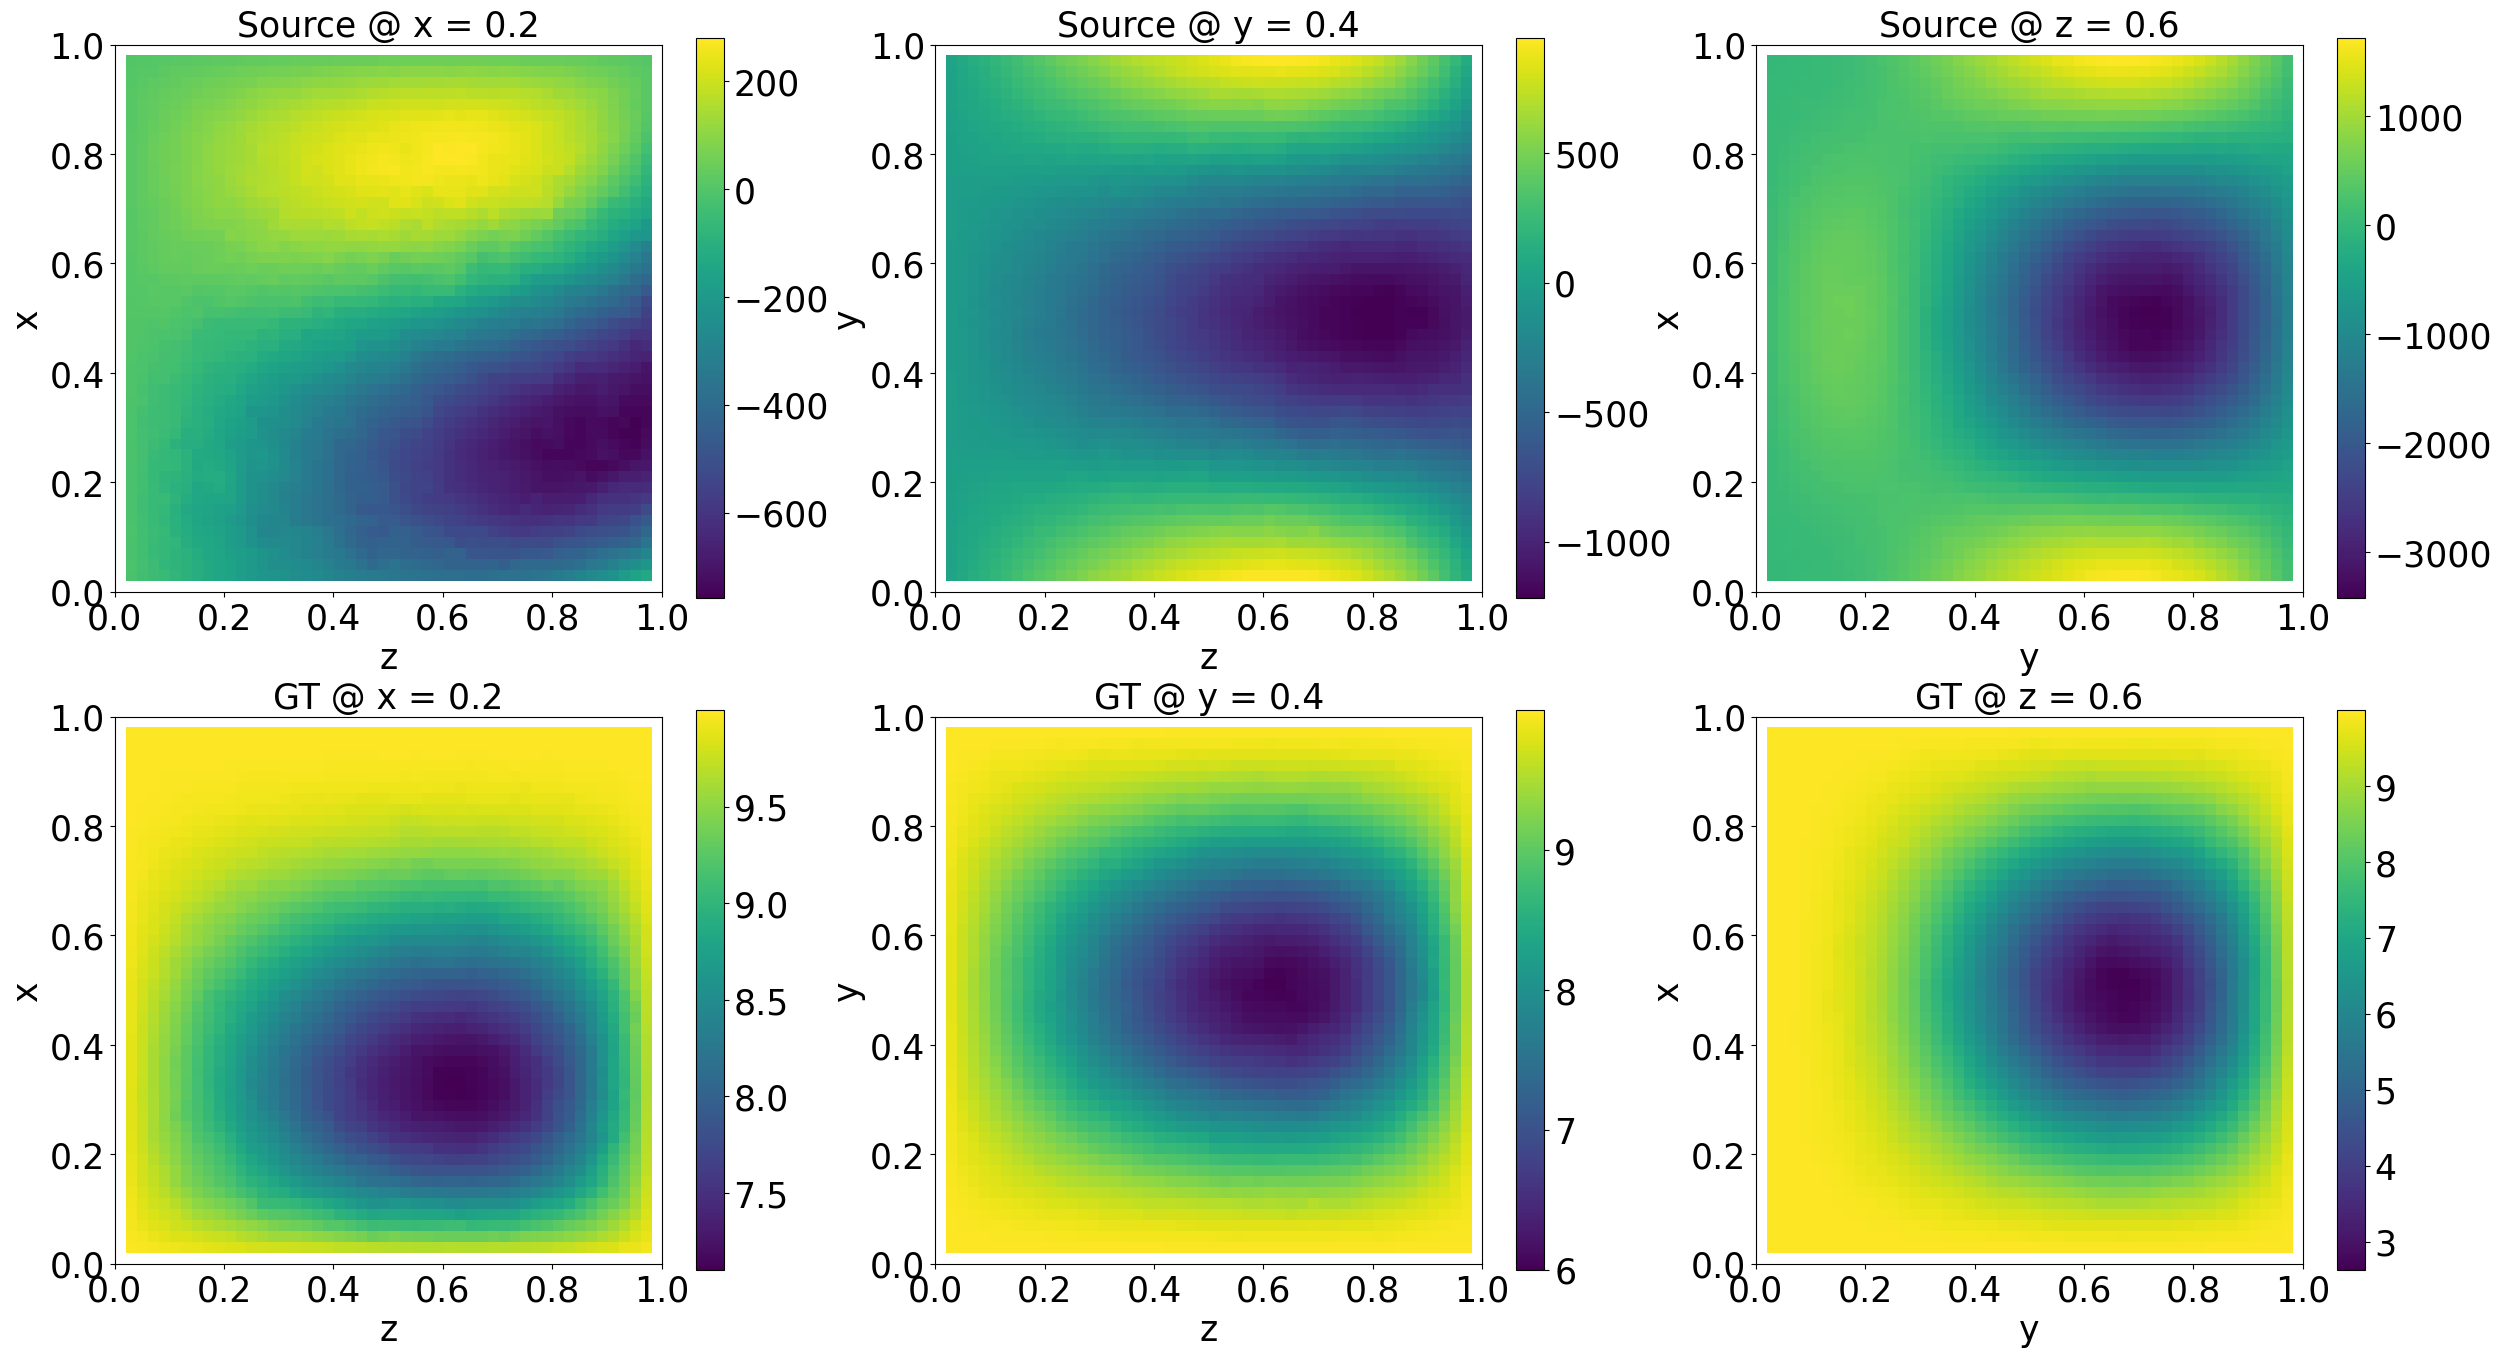

In [8]:
# visualize the result
gt_field = grid.gt
source_field = grid.source

from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import pylab

params = {
    "legend.fontsize": 18,
    "axes.labelsize": 25,
    "axes.titlesize": 25,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
}
pylab.rcParams.update(params)

# regular points:
mx, my, mz = jnp.meshgrid(
    jnp.linspace(0, 1, 50), jnp.linspace(0, 1, 50), jnp.linspace(0, 1, 50)
)
mxyz = jnp.concatenate((mx[..., None], my[..., None], mz[..., None]), axis=-1)
# interpolate
fig, ax = plt.subplots(2, 3, figsize=(30, 16))
# lw=1
cx = 10
cy = 20
cz = 30
inter_foi_yz = griddata(grid.c_pos, gt_field, mxyz[cx, :, :], method="linear")
inter_foi_xz = griddata(grid.c_pos, gt_field, mxyz[:, cy, :], method="linear")
inter_foi_xy = griddata(grid.c_pos, gt_field, mxyz[:, :, cz], method="linear")
inter_source_yz = griddata(grid.c_pos, source_field, mxyz[cx, :, :], method="linear")
inter_source_xz = griddata(grid.c_pos, source_field, mxyz[:, cy, :], method="linear")
inter_source_xy = griddata(grid.c_pos, source_field, mxyz[:, :, cz], method="linear")
data = [
    [inter_source_yz, inter_source_xz, inter_source_xy],
    [inter_foi_yz, inter_foi_xz, inter_foi_xy],
]
data_label = ["Source", "GT"]
for ii in range(2):
    imx = ax[ii, 0].imshow(data[ii][0], label="yz", extent=(0, 1, 0, 1))
    imy = ax[ii, 1].imshow(data[ii][1], label="xz", extent=(0, 1, 0, 1))
    imz = ax[ii, 2].imshow(data[ii][2], label="xy", extent=(0, 1, 0, 1))
    cbarx = fig.colorbar(imx)
    cbary = fig.colorbar(imy)
    cbarz = fig.colorbar(imz)
    ax[ii, 0].set_xlabel("z")
    ax[ii, 0].set_ylabel("x")
    ax[ii, 0].set_title(data_label[ii] + " @ x = " + str(cx / 50))
    ax[ii, 1].set_xlabel("z")
    ax[ii, 1].set_ylabel("y")
    ax[ii, 1].set_title(data_label[ii] + " @ y = " + str(cy / 50))
    ax[ii, 2].set_xlabel("y")
    ax[ii, 2].set_ylabel("x")
    ax[ii, 2].set_title(data_label[ii] + " @ z = " + str(cz / 50))

In [15]:
outputs

(GridVariable(cell_phi=Array([ 9.899573,  9.858428,  9.902692, ...,  9.999083, 10.002911,
        10.002176], dtype=float32), bd_phi=Array([10., 10., 10., ..., 10., 10., 10.], dtype=float32), bc=BoundaryConditions(bd_names=('bottom', 'top', 'left', 'right', 'front', 'back'), bd_types=('Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet'), bd_infos=(('bottom', 0, 'Uniform', 10.0, 17895, 18301), ('top', 0, 'Uniform', 10.0, 18301, 18707), ('left', 0, 'Uniform', 10.0, 18707, 19111), ('right', 0, 'Uniform', 10.0, 19111, 19517), ('front', 0, 'Uniform', 10.0, 19517, 19921), ('back', 0, 'Uniform', 10.0, 19921, 20325))), name='temp'),
 Array([[ 2.38418579e-07, -8.38190317e-07,  2.16066837e-07, ...,
          7.45058060e-08, -1.00117177e-08, -7.35744834e-08],
        [ 2.98023224e-08,  2.98023224e-08,  2.28174031e-08, ...,
          2.79396772e-09, -1.21071935e-08, -4.65661287e-09],
        [-5.40167093e-08,  5.58793545e-08,  0.00000000e+00, ...,
          4.65661287e-10,

In [20]:
solutions

GridVariable(cell_phi=Array([ 9.899573,  9.858428,  9.902692, ...,  9.999083, 10.002911,
       10.002176], dtype=float32), bd_phi=Array([10., 10., 10., ..., 10., 10., 10.], dtype=float32), bc=BoundaryConditions(bd_names=('bottom', 'top', 'left', 'right', 'front', 'back'), bd_types=('Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet'), bd_infos=(('bottom', 0, 'Uniform', 10.0, 17895, 18301), ('top', 0, 'Uniform', 10.0, 18301, 18707), ('left', 0, 'Uniform', 10.0, 18707, 19111), ('right', 0, 'Uniform', 10.0, 19111, 19517), ('front', 0, 'Uniform', 10.0, 19517, 19921), ('back', 0, 'Uniform', 10.0, 19921, 20325))), name='temp')

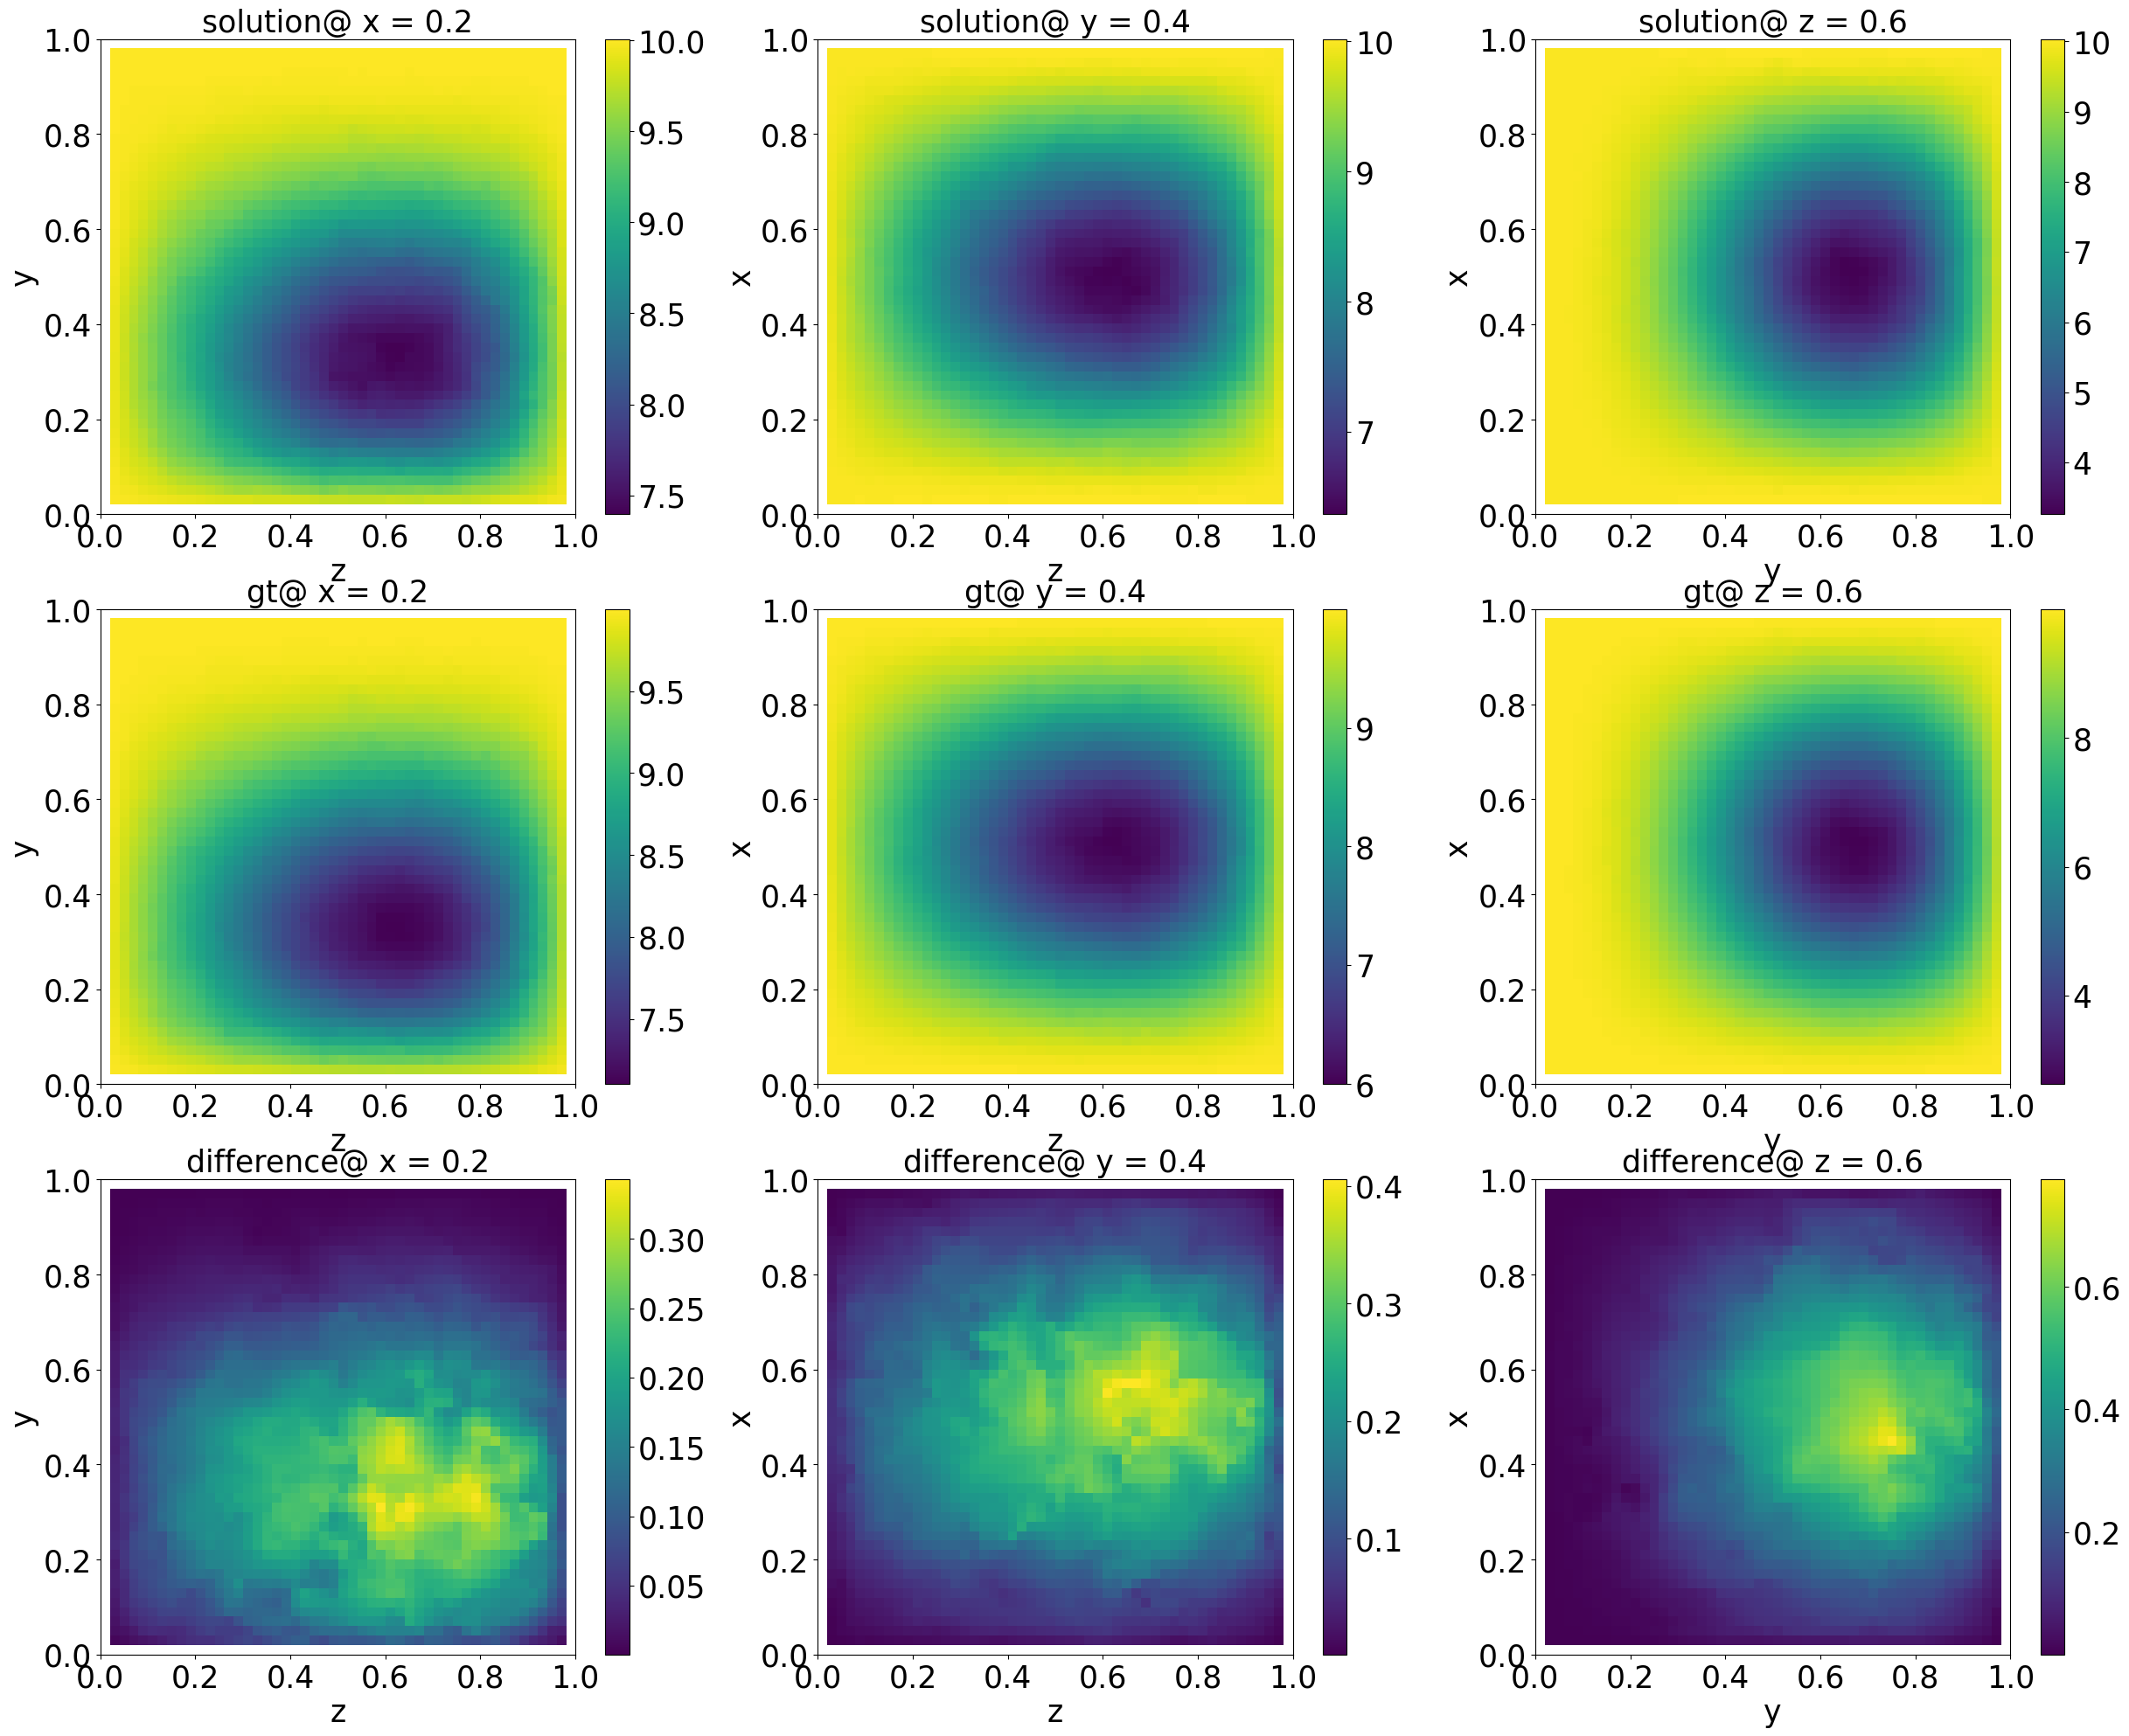

In [21]:
# visualize the calcuated results:
solutions, residuals = outputs

solution = solutions.cell_phi
fig, ax = plt.subplots(3, 3, figsize=(30, 24))
# lw=1
cx = 10
cy = 20
cz = 30
solution_inter_foi_yz = griddata(grid.c_pos, solution, mxyz[cx, :, :], method="linear")
solution_inter_foi_xz = griddata(grid.c_pos, solution, mxyz[:, cy, :], method="linear")
solution_inter_foi_xy = griddata(grid.c_pos, solution, mxyz[:, :, cz], method="linear")


gt_inter_foi_yz = griddata(grid.c_pos, gt_field, mxyz[cx, :, :], method="linear")
gt_inter_foi_xz = griddata(grid.c_pos, gt_field, mxyz[:, cy, :], method="linear")
gt_inter_foi_xy = griddata(grid.c_pos, gt_field, mxyz[:, :, cz], method="linear")

diff_inter_foi_yz = griddata(
    grid.c_pos, solution - gt_field, mxyz[cx, :, :], method="linear"
)
diff_inter_foi_xz = griddata(
    grid.c_pos, solution - gt_field, mxyz[:, cy, :], method="linear"
)
diff_inter_foi_xy = griddata(
    grid.c_pos, solution - gt_field, mxyz[:, :, cz], method="linear"
)


data = [
    [solution_inter_foi_yz, solution_inter_foi_xz, solution_inter_foi_xy],
    [gt_inter_foi_yz, gt_inter_foi_xz, gt_inter_foi_xy],
    [diff_inter_foi_yz, diff_inter_foi_xz, diff_inter_foi_xy],
]
data_labels = ["solution", "gt", "difference"]
for i in range(len(data)):
    imx = ax[i, 0].imshow(data[i][0], label="yz", extent=(0, 1, 0, 1))
    imy = ax[i, 1].imshow(data[i][1], label="xz", extent=(0, 1, 0, 1))
    imz = ax[i, 2].imshow(data[i][2], label="xy", extent=(0, 1, 0, 1))
    cbarx = fig.colorbar(imx)
    cbary = fig.colorbar(imy)
    cbarz = fig.colorbar(imz)
    ax[i, 0].set_xlabel("z")
    ax[i, 0].set_ylabel("y")
    ax[i, 0].set_title(data_labels[i] + "@ x = " + str(cx / 50))
    ax[i, 1].set_xlabel("z")
    ax[i, 1].set_ylabel("x")
    ax[i, 1].set_title(data_labels[i] + "@ y = " + str(cy / 50))
    ax[i, 2].set_xlabel("y")
    ax[i, 2].set_ylabel("x")
    ax[i, 2].set_title(data_labels[i] + "@ z = " + str(cz / 50))

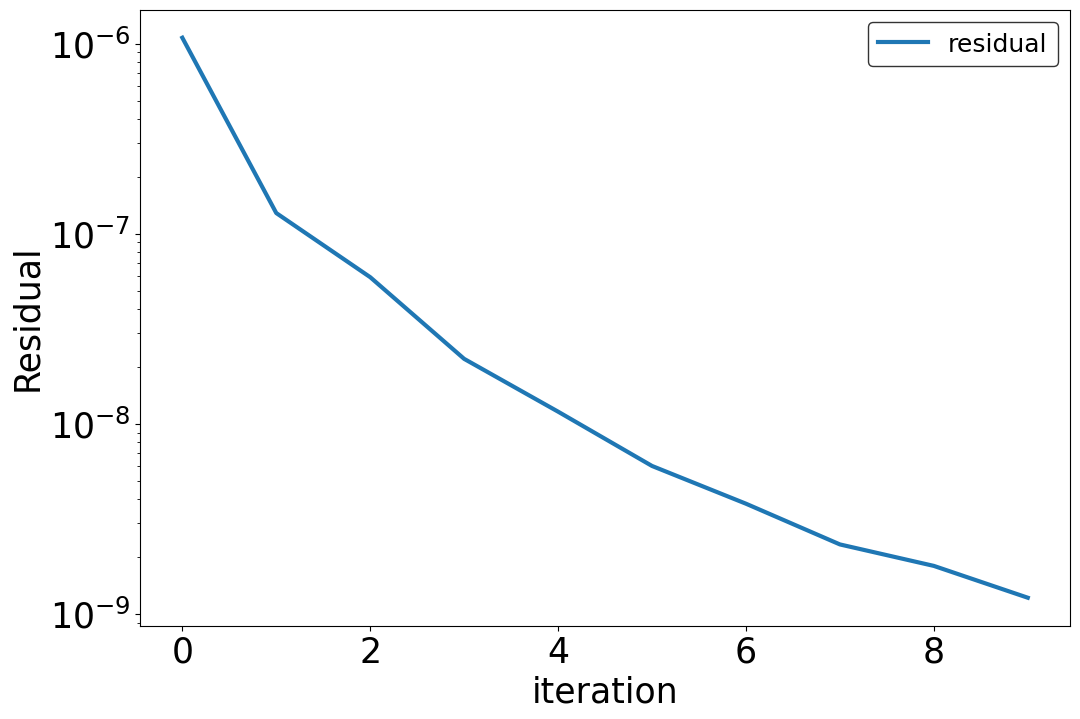

In [22]:
errors_dict = {"residual": np.array(jnp.mean(abs(residuals), axis=1))}
fig, ax = plt.subplots(figsize=(12, 8))
# lw=1
for key, value in errors_dict.items():
    ax.plot(value, label=key, linewidth=3)
ax.set_yscale("log")
ax.set_xlabel("iteration")
ax.set_ylabel("Residual")
leg = ax.legend(loc="upper right", frameon=True)
leg.get_frame().set_edgecolor("black")

Text(0, 0.5, 'speed up time')

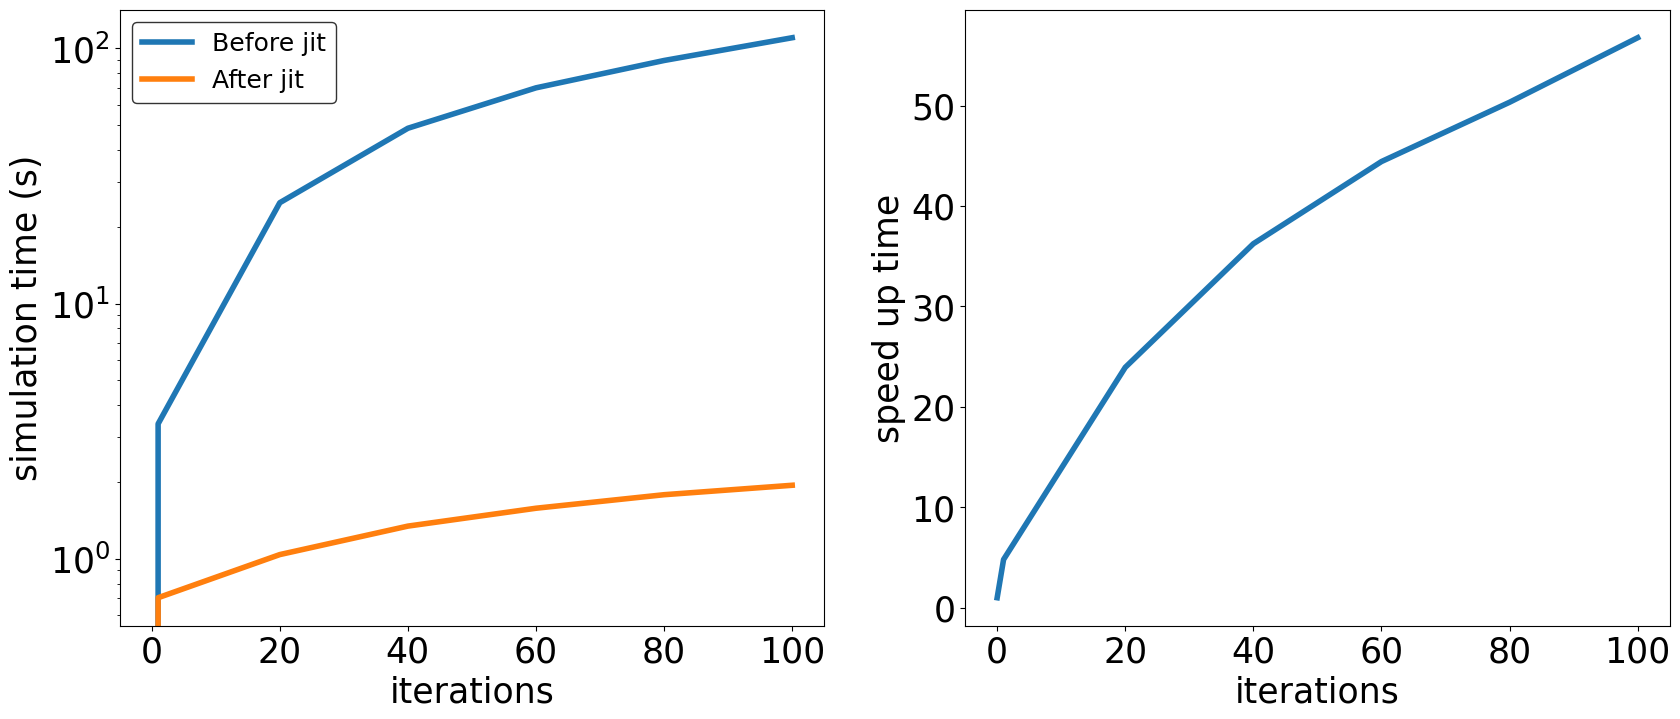

In [23]:
iterations = [0, 1, 20, 40, 60, 80, 100]
bt = [
    0.0,
    3.3794404231011868,
    24.864034295082092,
    48.68038315884769,
    70.11289007076994,
    89.74351878091693,
    110.20414558704942,
]
at = [
    0.0,
    0.7036607530899346,
    1.0386134251020849,
    1.3429005299694836,
    1.5779696176759899,
    1.7828289968892932,
    1.9414483993314207,
]

lw = 4
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(iterations, bt, label="Before jit", linewidth=lw)
ax[0].plot(iterations, at, label="After jit", linewidth=lw)
ax[0].set_yscale("log")
leg = ax[0].legend(frameon=True)
leg.get_frame().set_edgecolor("black")
ax[0].set_xlabel("iterations")
ax[0].set_ylabel("simulation time (s)")

ax[1].plot(
    iterations,
    [1.0] + [bt[i + 1] / at[i + 1] for i in range(len(at) - 1)],
    label="Before jit",
    linewidth=lw,
)
ax[1].set_xlabel("iterations")
ax[1].set_ylabel("speed up time")